In [2]:
# IMPORT
# Standard libray
import sys, os
from importlib import reload
sys.path.append("..")

# Common library
from tqdm import tqdm
import numpy as np
import scipy
from pylab import *
import scipy.interpolate

# ROOT>....
import ROOT
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)
# ROOT.gStyle.SetOptFit(1111)
import atlasplots as aplt
aplt.set_atlas_style()
ROOT.gStyle.SetTitleXOffset(1)
ROOT.gStyle.SetTitleYOffset(1.8)

# Custom helper functions
import MuHelper.muhelper.helper_basic as hp
import helper_tofpet as hptof

# ROOT.gStyle.SetPalette(len(hptof.mpl_colors), hptof.mpl_colors32)
ROOT.gStyle.SetPalette(ROOT.kViridis)
# colors=[int(c) for c in hptof.mpl_colors ]
colors=hptof.mpl_colors_cls()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Welcome to JupyROOT 6.30/04
Applying ATLAS style settings


In [3]:
working_dir = "/mnt/sda2/tofpet_data/test_stand_init/"
filename = working_dir+"data/"+  "full_cosmic_2_coinc.root"


coinc_pairs = np.loadtxt("../configurations/coinc_pairs.csv", delimiter=",", dtype=int)
coinc_pairs = {(a[0], a[1]):a[2] for a in coinc_pairs}


# Open root file

In [4]:
tfile = ROOT.TFile.Open(filename)

tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
entries = Tree.GetEntries()

print("Tree name:", tree_name)
print("Branches:", branches)
print("Entries:", entries)

Tree name: data
Branches: ['step1', 'step2', 'mh_n1', 'mh_j1', 'tot1', 'time1', 'channelID1', 'energy1', 'tacID1', 'xi1', 'yi1', 'x1', 'y1', 'z1', 'mh_n2', 'mh_j2', 'time2', 'channelID2', 'tot2', 'energy2', 'tacID2', 'xi2', 'yi2', 'x2', 'y2', 'z2']
Entries: 3318467


In [5]:
counts = {}
counts_energy_cut = {}
h_energy_min = {}
h_energy_avg = {}
h_dt = {}
h_dt_cut = {}

for pair in coinc_pairs:
    pair_id = coinc_pairs[pair]
    h_energy_min[pair_id] = ROOT.TH1D(f"energy_min_{pair_id}", ";Energy [ns];count", 100,-10,120)
    h_energy_avg[pair_id] = ROOT.TH1D(f"energy_avg_{pair_id}", ";Energy [ns];count", 100,-10,120)
    h_dt[pair_id]         = ROOT.TH1D(f"dt_{pair_id}", ";t1-t2 [ns];count", 200, -30, 30)
    h_dt_cut[pair_id]     = ROOT.TH1D(f"dt_cut_{pair_id}", ";t1-t2 [ns];count", 200, -30, 30)
    counts[pair_id]=0
    counts_energy_cut[pair_id]=0

for i in tqdm(range(entries)):
# for i in range(1000000):
    Tree.GetEntry(i)

    # Process if the coincidence pair is one of our requested pairs
    ch1, ch2 = Tree.channelID1,  Tree.channelID2
    if (ch1,ch2) not in coinc_pairs:
        continue

    pair_id = coinc_pairs[(ch1,ch2)]
    energy_min = min(Tree.energy1, Tree.energy2)
    energy_avg = 0.5*(Tree.energy1 + Tree.energy2)
    dt = 0.001*(Tree.time1 - Tree.time2)

    counts[pair_id]+=1
    h_energy_min[pair_id].Fill(energy_min)
    h_energy_avg[pair_id].Fill(energy_avg)
    h_dt[pair_id].Fill(dt)

    # Cut on dt:
    if energy_min>20:
        counts_energy_cut[pair_id]+=1
        h_dt_cut[pair_id].Fill(dt)


100%|██████████| 3318467/3318467 [00:56<00:00, 58925.16it/s]


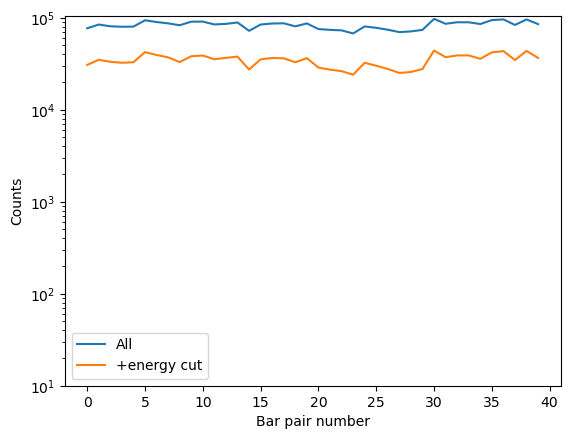

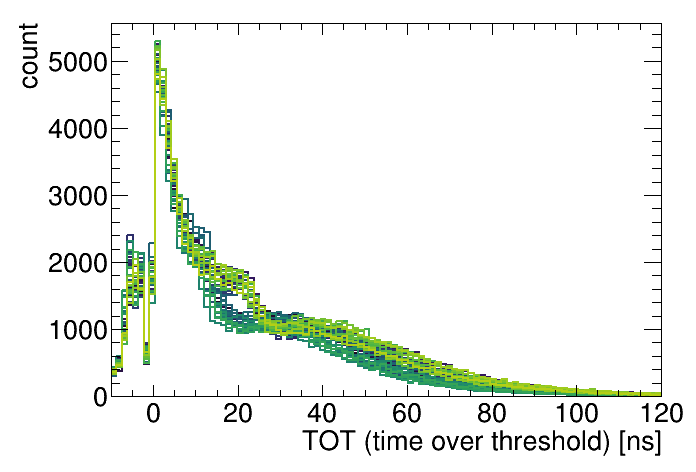

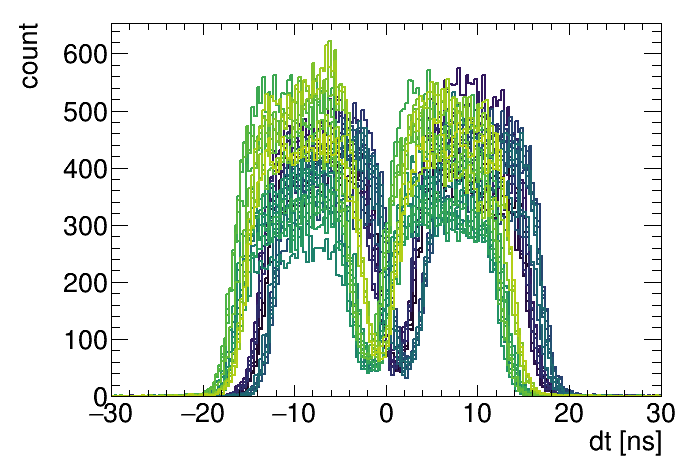

In [6]:
x = np.arange(len(counts.keys()))
x_label = list(counts.keys())

y1 = [counts[a] for a in counts]
y2 = [counts_energy_cut[a] for a in counts]
plot(x, y1, label="All")
plot(x, y2, label="+energy cut")
xlabel("Bar pair number")
ylabel("Counts")
yscale("log")
legend()
ylim(10,)

# Plot energy distribution
c_energy=ROOT.TCanvas("c_energy"); c_energy.Draw();
hs = ROOT.THStack("hs","TOT_min;Energy (time over threshold) [ns];count")
for pair in coinc_pairs:
    pair_id = coinc_pairs[pair]
    hs.Add(h_energy_min[pair_id])

hs.Draw("PLC nostack")
# c_energy.SetLogy()


# Plot all dt distribution
c_dt=ROOT.TCanvas("c_dt"); c_dt.Draw();
hs_dt = ROOT.THStack("hs","TOT_min;dt [ns];count")
for pair in coinc_pairs:
    pair_id = coinc_pairs[pair]
    hs_dt.Add(h_dt_cut[pair_id])

hs_dt.Draw("PLC nostack")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      29.6393
NDf                       =           36
Edm                       =  4.69895e-07
NCalls                    =          153
p0                        =      170.177   +/-   2.21968     
p1                        =     -13.1999   +/-   0.0497209   
p2                        =      1.12214   +/-   0.0395194   
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      80.7715
NDf                       =           62
Edm                       =  1.72186e-07
NCalls                    =          134
p0                        =      182.231   +/-   1.49539     
p1                        =      3.13342   +/-   0.0422923   
p2                        =      1.14234   +/-   0.0313759   
p3                        =    -0.507517   +/-   0.0434277   
****************************************
Minimizer is Minuit2 / Migrad
Chi2                     

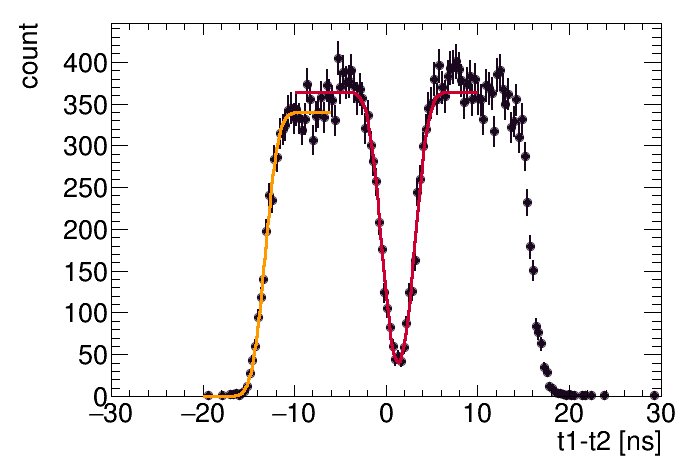

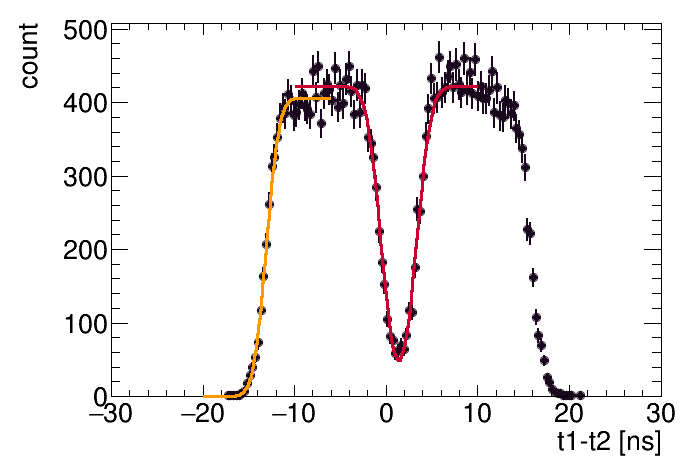

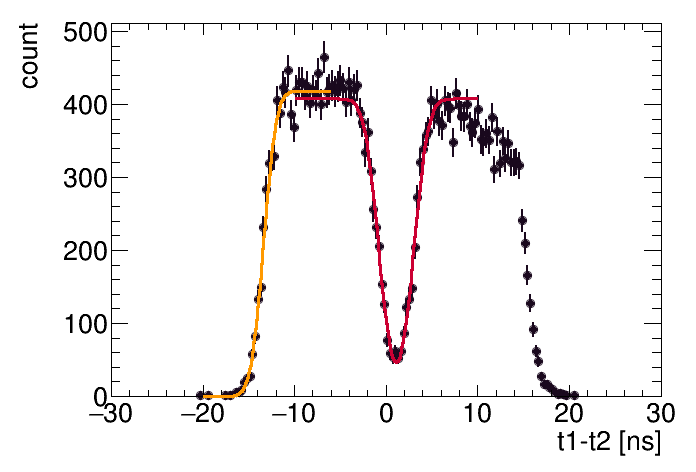

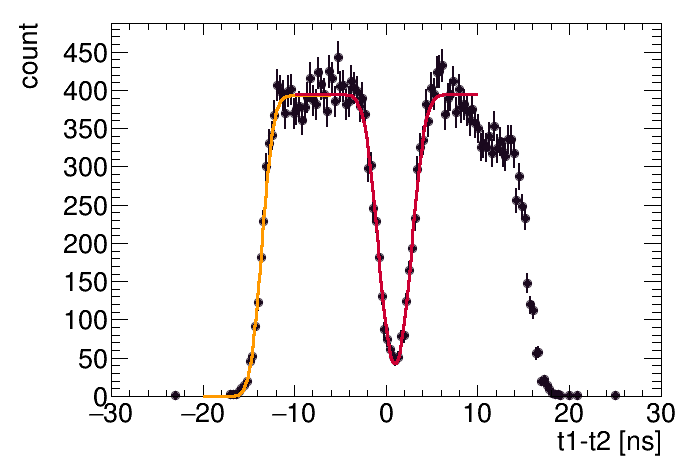

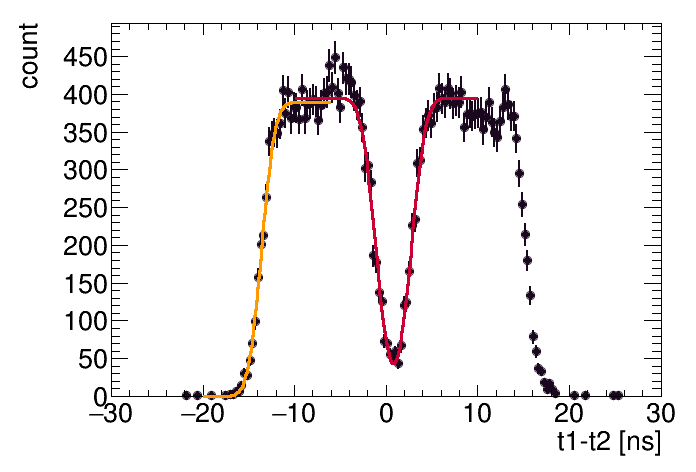

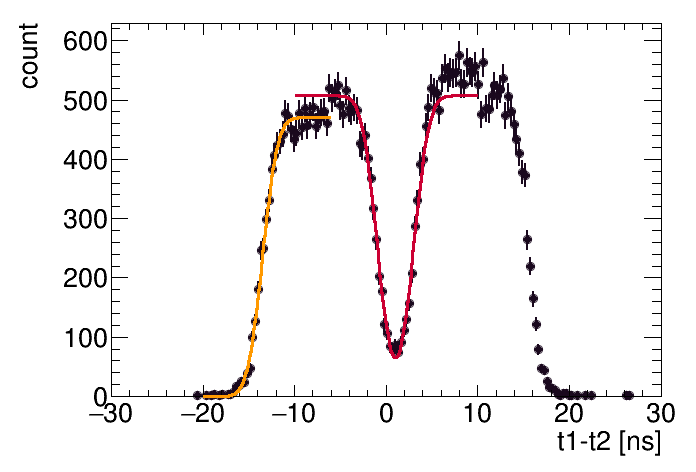

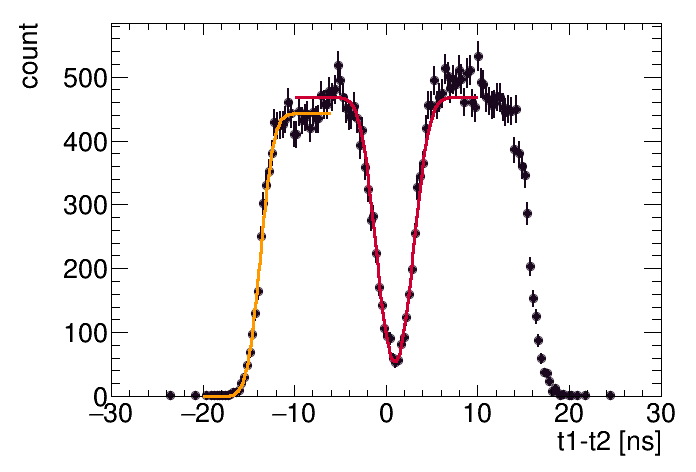

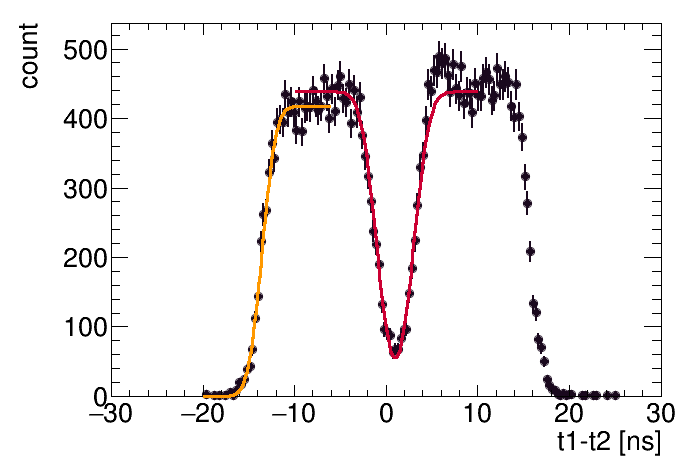

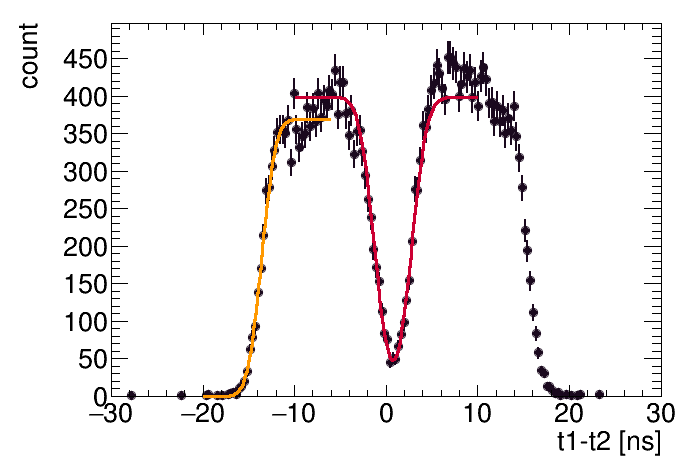

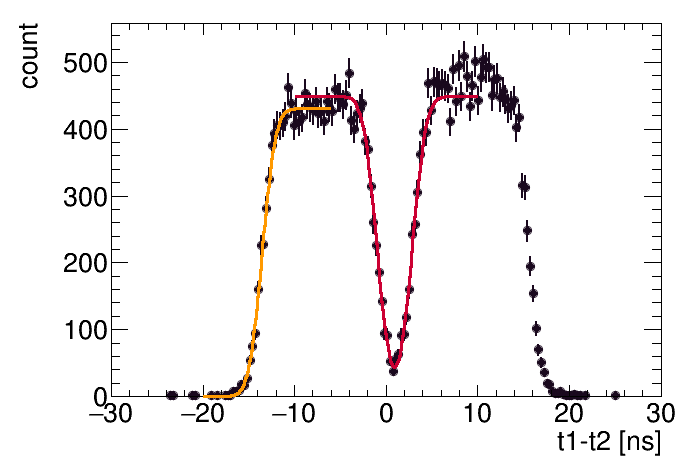

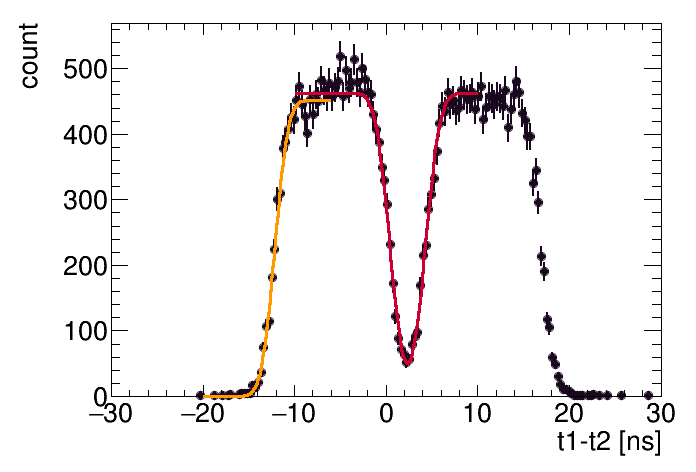

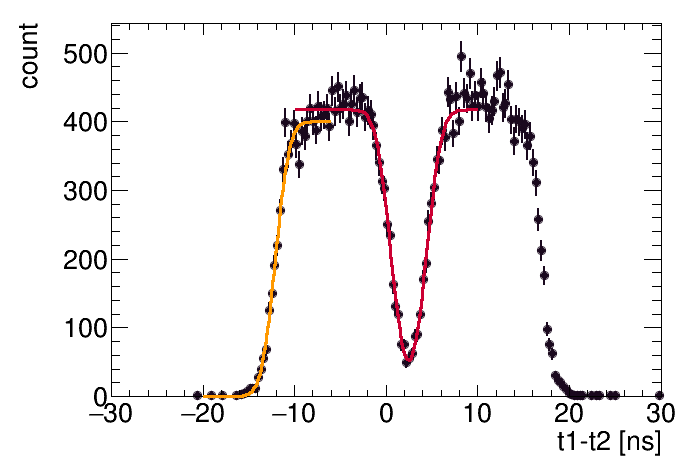

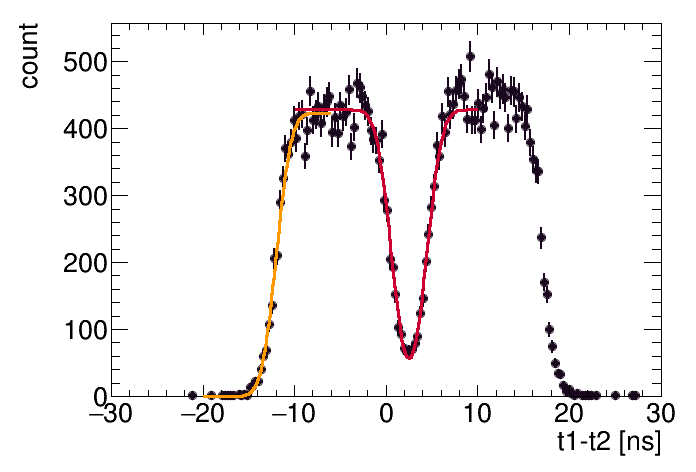

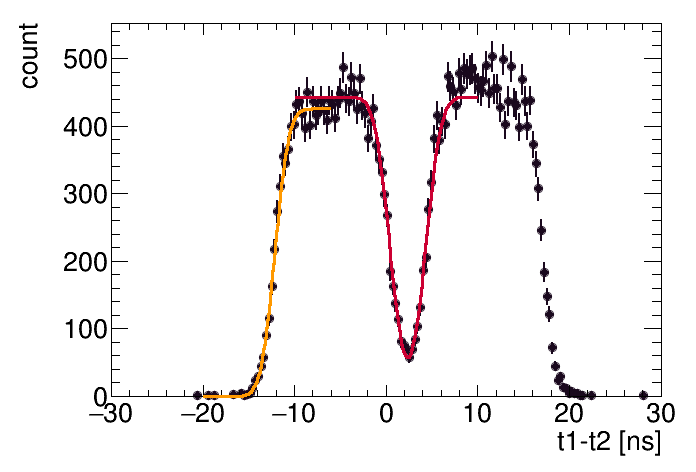

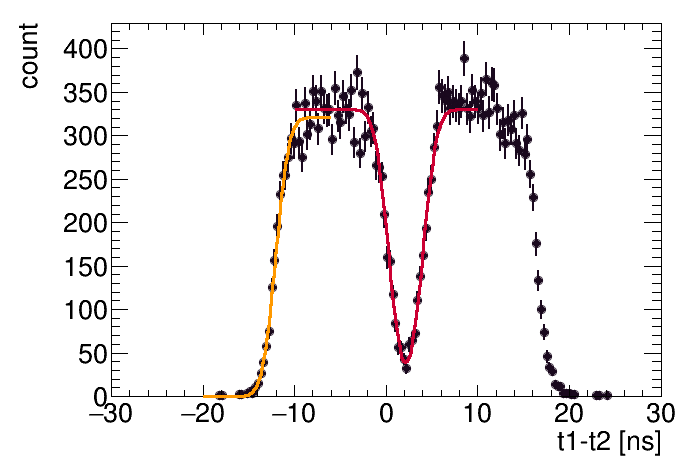

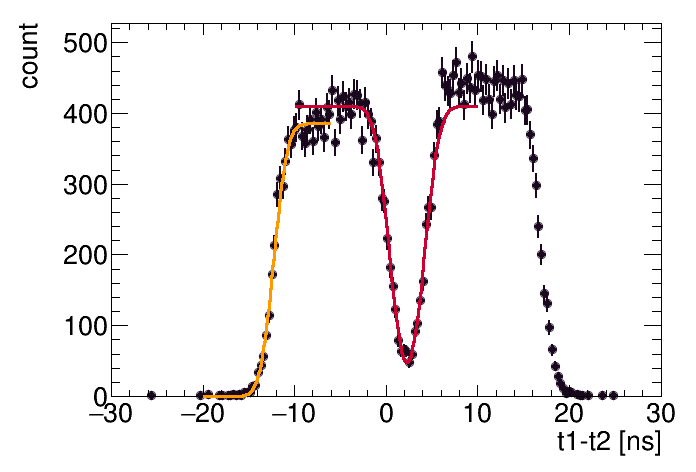

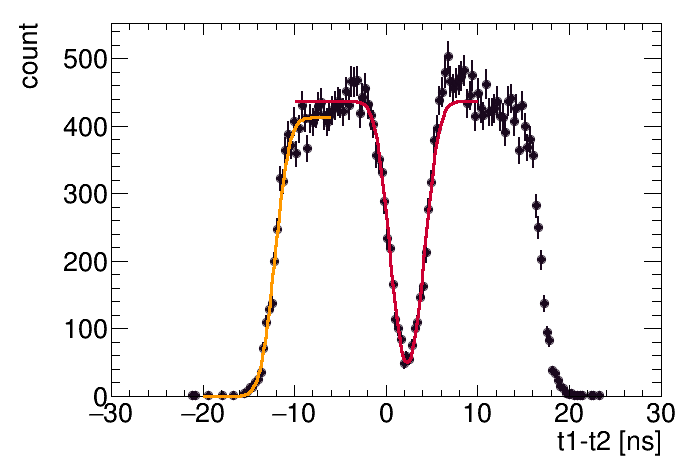

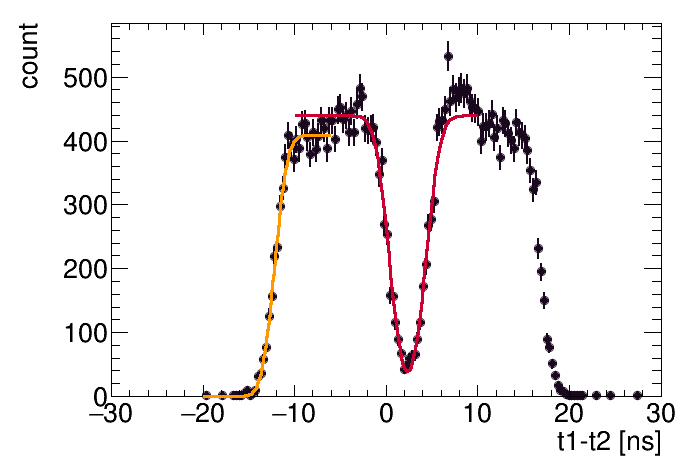

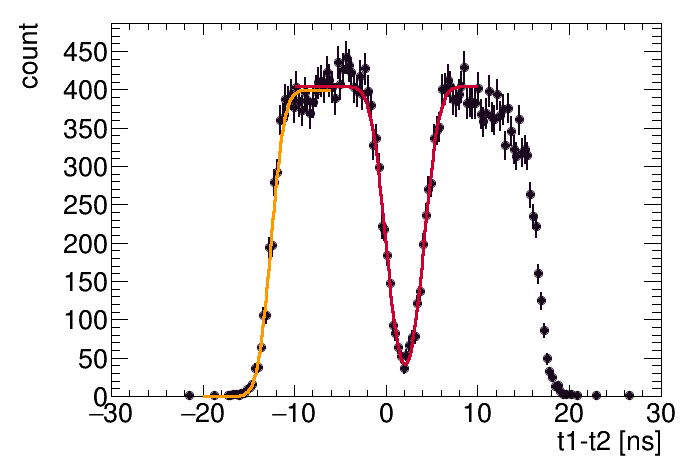

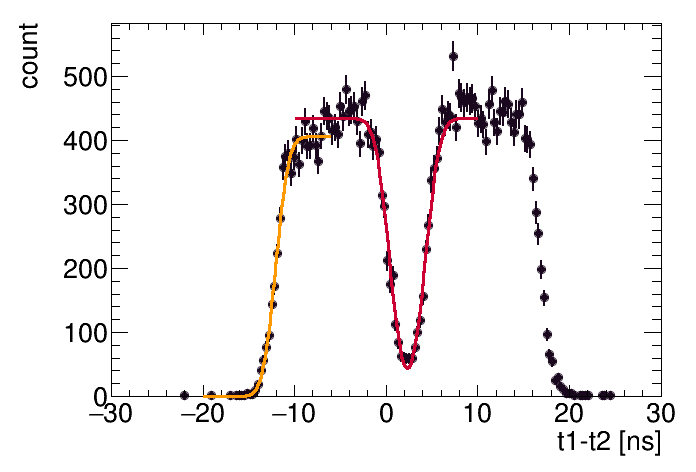

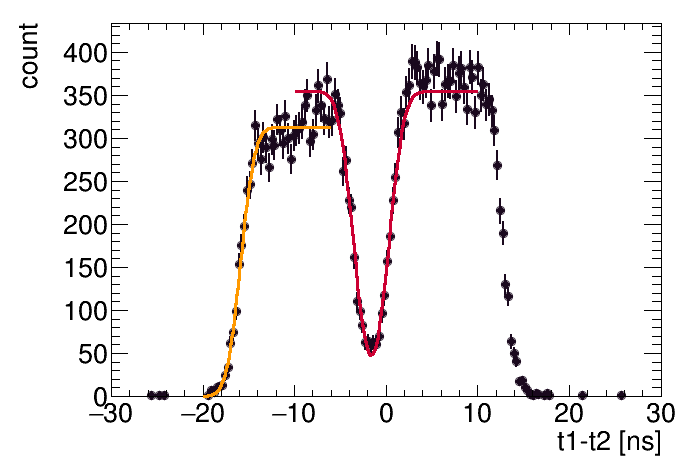

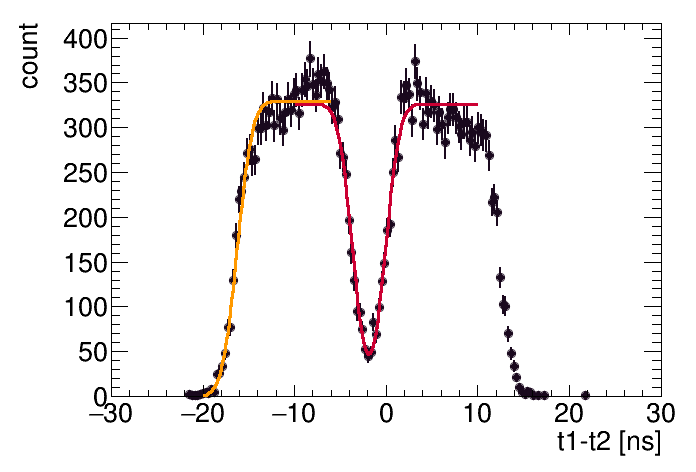

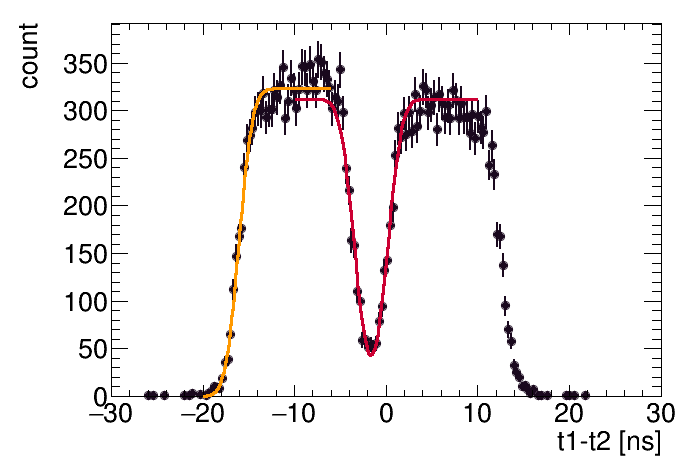

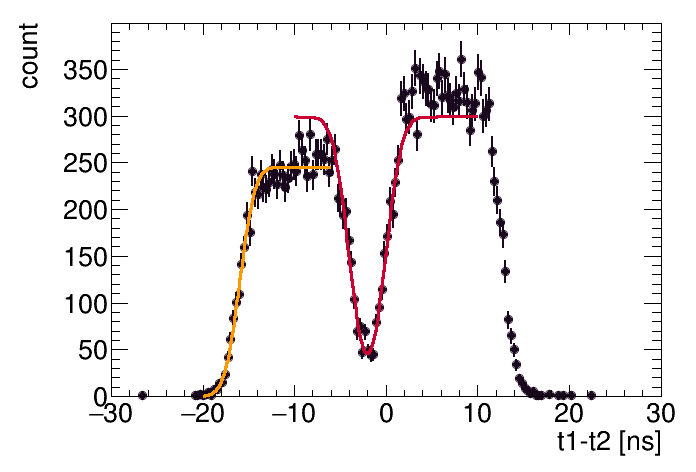

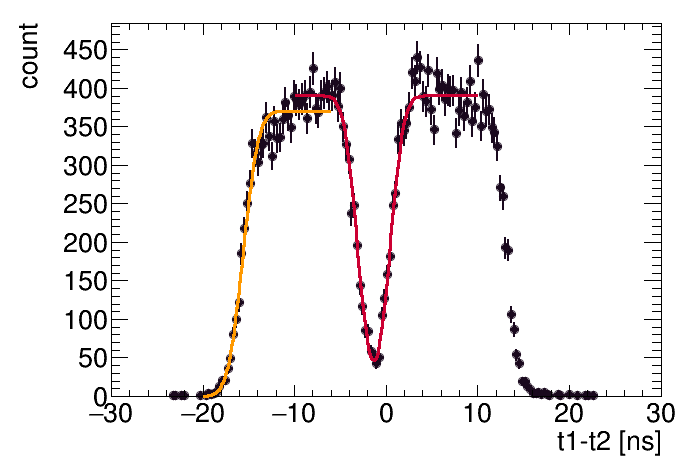

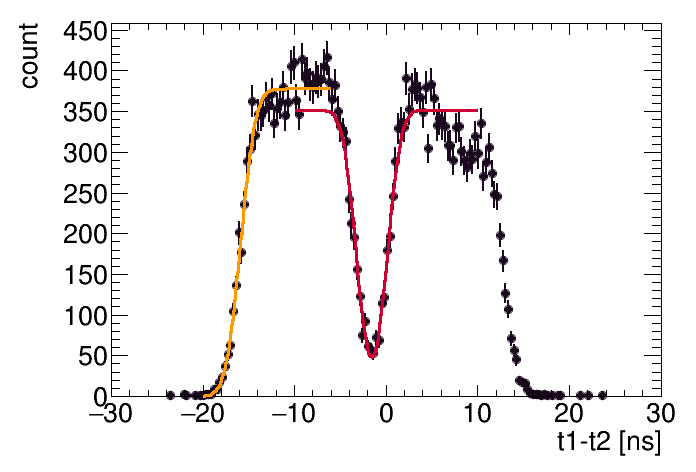

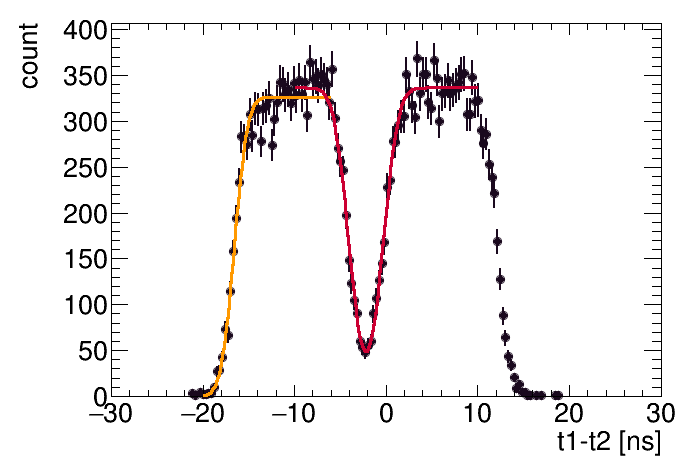

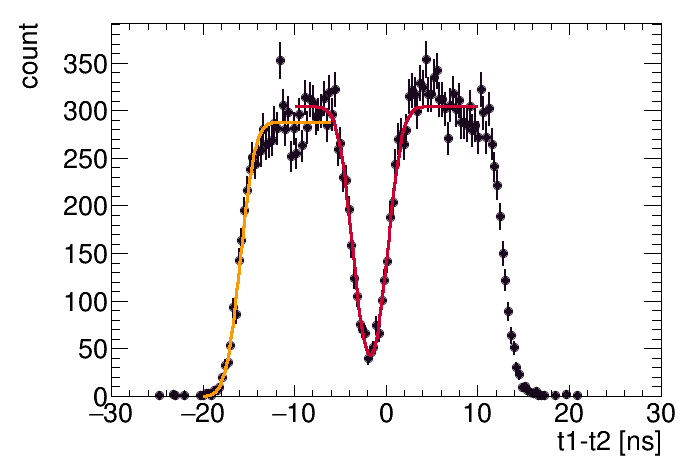

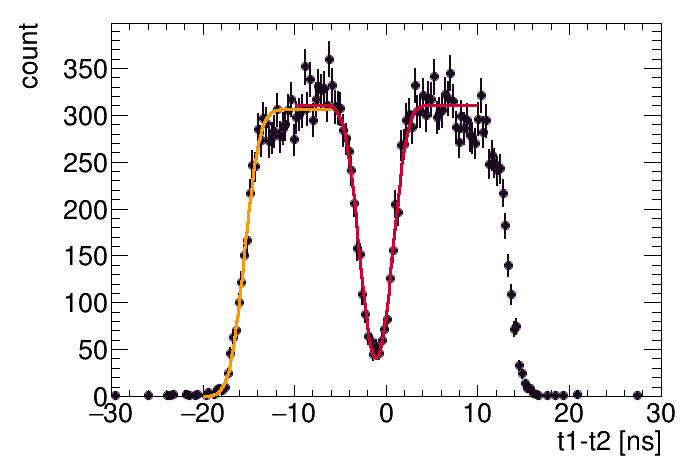

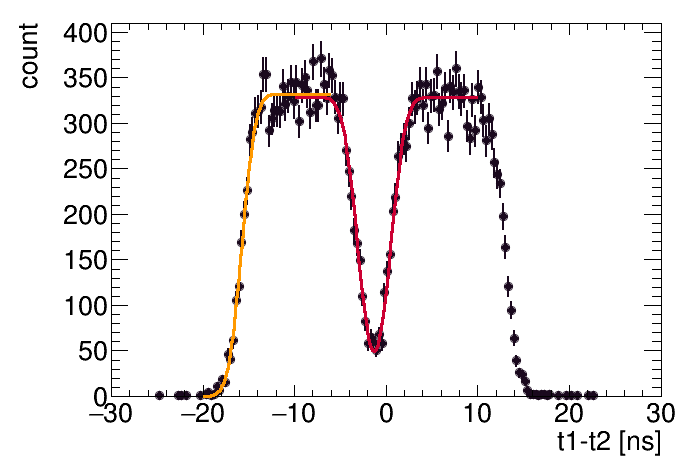

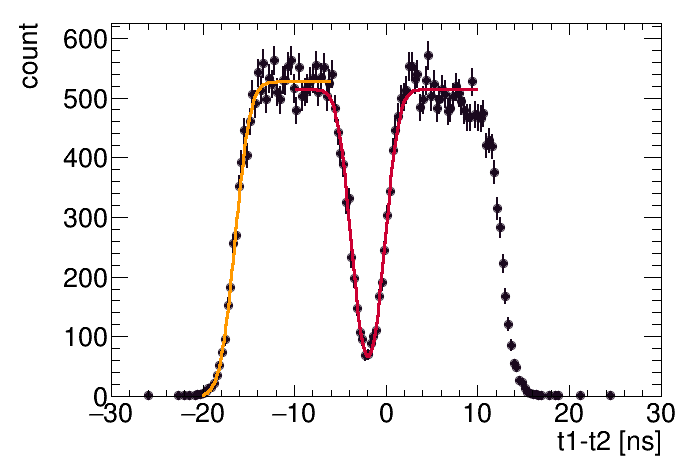

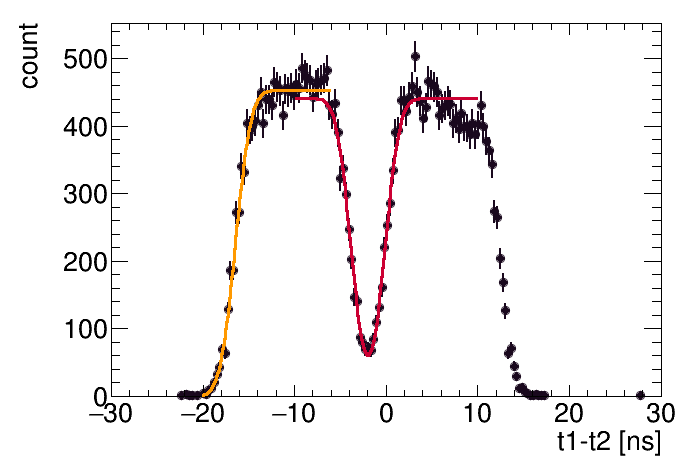

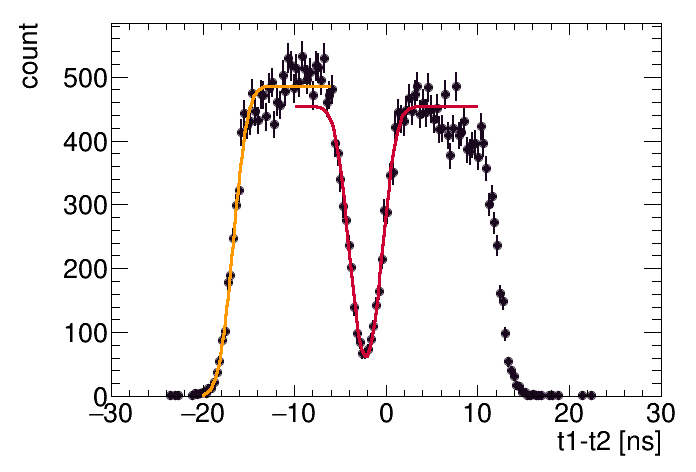

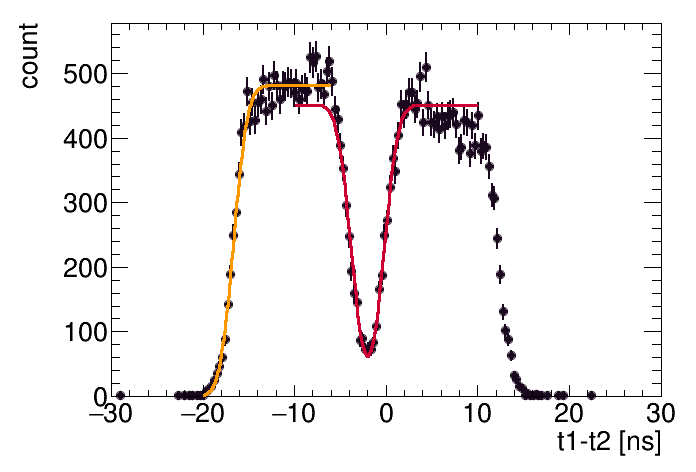

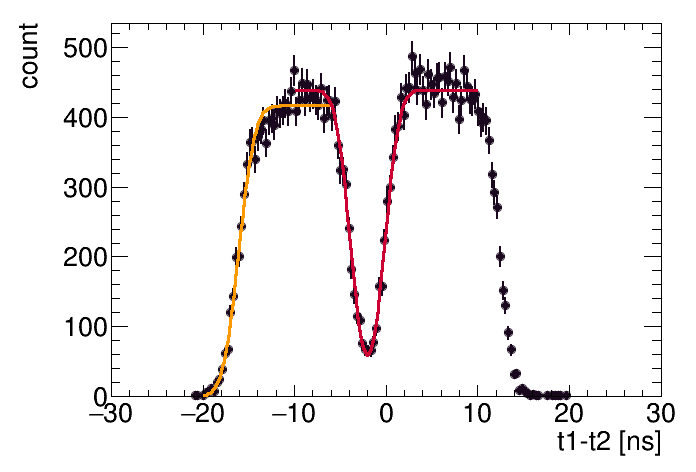

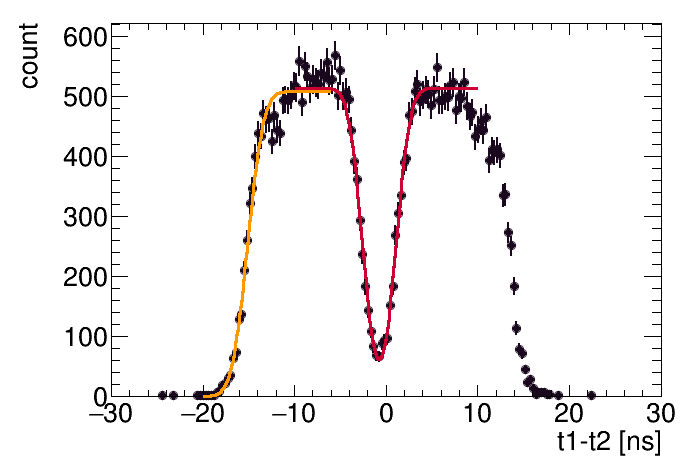

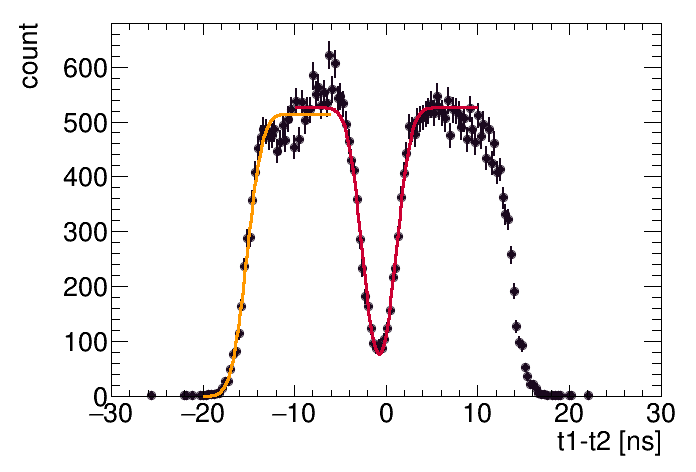

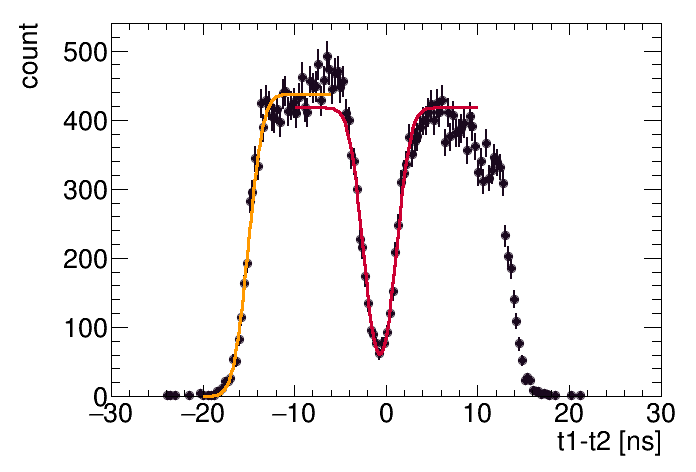

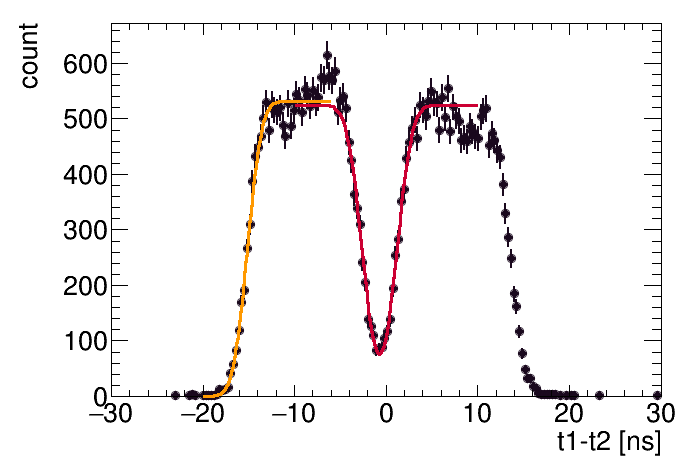

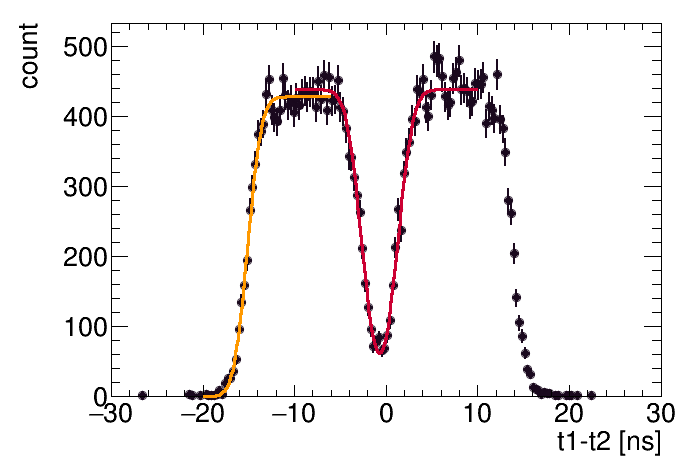

In [47]:
dt_fit_results={}
dt_bar = []
dt_gap = []
c_dt_fits=[] # Use the list to hold all canvas
for pair in coinc_pairs:
# if 1:
    pair_id = coinc_pairs[pair]


    # Canvas
    c_dt_fits.append(ROOT.TCanvas()); 
    c1=c_dt_fits[-1]
    c1.Draw()

    # Hist
    h1=h_dt_cut[pair_id]
    h1.Draw("E PLC PMC",)

    # Fit an error function to the left edge
    f1 = ROOT.TF1('f1', '[0] * TMath::Erf((x - [1])/(1.4142*[2])) + [0]', -20, -6)
    f1.SetParameters(300, -7, 0.7)
    ROOT.Math.MinimizerOptions.SetDefaultTolerance(0.1)
    h1.Fit(f1, "RS0")
    f1.SetLineColor(int(colors[1]))
    f1.Draw("SAME")

    # Fit two error function to the middle
    f2 = ROOT.TF1('f2', '[0] * TMath::Erf((x - [1])/(1.4142*[2])) + [0] * TMath::Erf((-(x- [3]))/(1.4142*[2]))  + [0]*2', -10, 10)
    f2.SetParameters(150, 1, 0.7, -1)
    # ROOT.Math.MinimizerOptions.SetDefaultTolerance(0.1)
    # ROOT.Math.MinimizerOptions.SetDefaultPrecision(1e-7)
    h1.Fit(f2, "RS0")
    f2.SetLineColor(int(colors[3]))
    f2.Draw("SAME")


    # ROOT.gPad.BuildLegend();


    # Save result
    dt_fit_results[pair_id] = 0.5*(f2.GetParameter(1)+f2.GetParameter(3))
    dt_bar.append(f2.GetParameter(3) - f1.GetParameter(1))
    dt_gap.append(f2.GetParameter(1) - f2.GetParameter(3))

In [26]:
# Upate the CSV file
from functools import reduce
def update_time_calib(filename, pair_info, verbose=False):
    # Open the file
    with open(filename, 'r') as f:
        output = [f.readline()]
        for line in f:
            output.append(line)


    # Update the content
    for key in pair_info:
        offset = pair_info[key]
        

        for iline in range(1, len(output)):
            line = output[iline].split(",")
            content = [int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])]
            if content[0]==key:
                # Print only if the new value is different from the old one
                if content[1]!=offset:
                    print("Pair", key, "offset old", content[1], ", offset new", offset)
                content[1] = offset
                output[iline] = reduce(lambda x, y: str(x) + ',' + str(y), content)+"\n"
                continue


    # Write the file
    os.rename(filename, filename+".backup")
    with open(filename, 'w', newline='') as f:
        f.writelines(output)




filename_time_calib = "../configurations/MATHUSLA teststand pinout - Channel_pair.csv"
update_time_calib(filename_time_calib, dt_fit_results)        

In [55]:
n_fiber = 1.77
dt_bar = np.array(dt_bar)
dt_gap = np.array(dt_gap)

bar_len = dt_bar/2*29.979/n_fiber
gap_len = dt_gap/2*29.979/n_fiber

print("Mean bar length [cm]", np.mean(bar_len))
print("Mean gap length [cm]", np.mean(gap_len))

Mean bar length [cm] 105.79703054115404
Mean gap length [cm] 32.34585474378041
